<a href="https://colab.research.google.com/github/Alisser2001/QuantumMachineLearning/blob/main/BaseballhybridSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit_aer                   #simulacion de alto desempeño
!pip install "qiskit[visualization]"      #visualizacion de los circitos cuanticos
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install optuna



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 110.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=1e9c2299c8e1f79b428b2eaf6d3b76fb45110c13fe89793f718f1d9ea54b07af
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from qiskit import *
from qiskit.visualization import *
from qiskit_aer import *

#--- Pipeline final ------

In [ ]:
# ============================================================
# CQ-Optuna v9: Optuna por (modo × n_qubits) - 3 trials por configuración
# ============================================================
import os, time, requests, numpy as np, pandas as pd, matplotlib.pyplot as plt, optuna
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.visualization import circuit_drawer

# ---------------- CONFIG ----------------
RESULTS_DIR = "cq_v9_optuna_outputs"
os.makedirs(f"{RESULTS_DIR}/figs", exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/circuits", exist_ok=True)

QUBITS_LIST = [4, 6, 8, 10, 12]
MODES = ["Z", "Z+ZZ", "Pauli", "Angle", "Fourier", "RandomizedPauli"]
N_TRIALS = 3

# ---------------- DATASET ----------------
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/baseball.dat"
resp = requests.get(url)
lines = [line.strip() for line in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.startswith("@attribute")]
data_start = lines.index("@data") + 1
data = [line.split(",") for line in lines[data_start:] if line]
df = pd.DataFrame(data, columns=attributes).astype(float)

X_full, y_full = df.drop(columns=["Salary"]).values, df["Salary"].values
sc_raw = StandardScaler().fit(X_full)
X_scaled = sc_raw.transform(X_full)
mask = LocalOutlierFactor(n_neighbors=20, contamination=0.05).fit_predict(X_scaled) == 1
X, y = X_full[mask], y_full[mask]
print(f"[LOF] Muestras: {len(df)} → {len(X)} (removidos {len(df)-len(X)})")

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
y_tr, y_te = np.log1p(y_tr), np.log1p(y_te)

# ---------------- UTILIDADES ----------------
def build_observables(n_qubits):
    paulis = []
    for i in range(n_qubits):
        mask = ["I"] * n_qubits
        mask[i] = "Z"
        paulis.append(SparsePauliOp("".join(mask)))
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            mask = ["I"] * n_qubits
            mask[i] = mask[j] = "Z"
            paulis.append(SparsePauliOp("".join(mask)))
    return paulis

def make_circuit(x, n, mode):
    if mode == "Z":
        qc = QuantumCircuit(n)
        for i,val in enumerate(x[:n]): qc.rz(float(val), i)
        return qc
    if mode == "Z+ZZ":
        fm = ZZFeatureMap(feature_dimension=n, reps=2, entanglement="full")
        return fm.assign_parameters(dict(zip(fm.parameters, x[:n])))
    if mode == "Pauli":
        fm = PauliFeatureMap(feature_dimension=n, reps=2, paulis=["X","Y","Z"])
        return fm.assign_parameters(dict(zip(fm.parameters, x[:n])))
    if mode == "Angle":
        qc = QuantumCircuit(n)
        for i,val in enumerate(x[:n]): qc.ry(float(val), i)
        for i in range(n-1): qc.cz(i,i+1)
        return qc
    if mode == "Fourier":
        qc = QuantumCircuit(n)
        for i,val in enumerate(x[:n]):
            qc.h(i); qc.rz(2*np.pi*float(val), i)
        for i in range(n-1): qc.cz(i,i+1)
        return qc
    if mode == "RandomizedPauli":
        qc = QuantumCircuit(n)
        rng = np.random.default_rng(42)
        for i,val in enumerate(x[:n]): qc.ry(float(val), i)
        for _ in range(2):
            for i in range(n): getattr(qc, rng.choice(["x","y","z"]))(i)
            for i in range(n-1): qc.cz(i,i+1)
        return qc
    raise ValueError(mode)

def circuit_metrics(qc):
    return {
        "depth": qc.depth(),
        "size": qc.size(),
        "multi_qubit_gates": sum(1 for g in qc.data if len(g.qubits)>1),
        "parameters": len(qc.parameters),
        "num_qubits": qc.num_qubits,
        "ops": qc.count_ops()
    }

def quantum_features(Xb, n_qubits, mode):
    paulis = build_observables(n_qubits)
    feats, qc_sample = [], None
    for x in Xb:
        qc = make_circuit(x, n_qubits, mode)
        if qc_sample is None: qc_sample = qc
        psi = Statevector.from_instruction(qc)
        feats.append([float(np.real(psi.expectation_value(p))) for p in paulis])
    return np.array(feats), qc_sample

# ---------------- EXPERIMENTO POR CONFIG ----------------
def run_experiment(mode, n_qubits, C, epsilon, kernel):
    scaler = StandardScaler().fit(X_tr)
    Xtr, Xte = scaler.transform(X_tr), scaler.transform(X_te)
    pca = PCA(n_components=n_qubits).fit(Xtr)
    Xtr_p, Xte_p = pca.transform(Xtr), pca.transform(Xte)

    t0 = time.time()
    Z_tr, qc_sample = quantum_features(Xtr_p, n_qubits, mode)
    Z_te, _ = quantum_features(Xte_p, n_qubits, mode)
    Xh_tr, Xh_te = np.hstack([Xtr_p,Z_tr]), np.hstack([Xte_p,Z_te])

    model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    model.fit(Xh_tr, y_tr)
    y_pred = model.predict(Xh_te)
    elapsed = time.time() - t0

    return {
        "MSE": mean_squared_error(y_te, y_pred),
        "MAE": mean_absolute_error(y_te, y_pred),
        "R2": r2_score(y_te, y_pred),
        "time": elapsed,
        "qc_sample": qc_sample
    }

# ---------------- LOOP GLOBAL ----------------
records = []
for q in QUBITS_LIST:
    for mode in MODES:
        print(f"\n=== Optimizando {mode} con {q} qubits ===")

        def objective(trial):
            C = trial.suggest_float("C", 0.1, 10, log=True)
            epsilon = trial.suggest_float("epsilon", 0.01, 0.3)
            kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
            metrics = run_experiment(mode, q, C, epsilon, kernel)
            trial.set_user_attr("qc_sample", metrics["qc_sample"])
            trial.set_user_attr("time", metrics["time"])
            return metrics["MSE"]

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

        best = study.best_trial
        qc_best = best.user_attrs["qc_sample"]
        circ_data = circuit_metrics(qc_best)

        rec = {
            "mode": mode,
            "qubits": q,
            "best_MSE": best.value,
            "best_C": best.params["C"],
            "best_epsilon": best.params["epsilon"],
            "best_kernel": best.params["kernel"],
            "depth": circ_data["depth"],
            "size": circ_data["size"],
            "multi_qubit_gates": circ_data["multi_qubit_gates"],
            "num_qubits": circ_data["num_qubits"],
            "ops": circ_data["ops"],
            "time": best.user_attrs["time"]
        }
        records.append(rec)
        print(f"→ Mejor trial: MSE={rec['best_MSE']:.6f}, "
              f"kernel={rec['best_kernel']}, C={rec['best_C']:.3f}, eps={rec['best_epsilon']:.3f}")

# ---------------- RESULTADOS ----------------
df = pd.DataFrame(records)
df.to_csv(f"{RESULTS_DIR}/cq_v9_best_results.csv", index=False)
print("\n[OK] Resultados guardados:", f"{RESULTS_DIR}/cq_v9_best_results.csv")
print(df[["mode","qubits","best_MSE","best_kernel","best_C","best_epsilon","depth","multi_qubit_gates"]])

# ---------------- PLOTS ----------------
plt.figure(figsize=(10,6))
for m in MODES:
    sub = df[df.mode==m].sort_values("qubits")
    plt.plot(sub.qubits, sub.best_MSE, marker='o', label=m)
plt.title("Mejor MSE por modo y nº de qubits (Optuna 3 trials)")
plt.xlabel("Qubits"); plt.ylabel("MSE"); plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/figs/mse_vs_qubits_best.png", dpi=160)
plt.show()


[I 2025-11-10 12:44:41,486] A new study created in memory with name: no-name-1b709103-8e85-46aa-b0ff-f19efad22ec5


[LOF] Muestras: 337 → 320 (removidos 17)

=== Optimizando Z con 4 qubits ===


[I 2025-11-10 12:44:42,626] Trial 0 finished with value: 0.7354682371815167 and parameters: {'C': 0.16548468800373964, 'epsilon': 0.06856913701845475, 'kernel': 'linear'}. Best is trial 0 with value: 0.7354682371815167.
[I 2025-11-10 12:44:43,824] Trial 1 finished with value: 0.547831847545888 and parameters: {'C': 0.5232734143285048, 'epsilon': 0.10951974501068966, 'kernel': 'poly'}. Best is trial 1 with value: 0.547831847545888.
[I 2025-11-10 12:44:44,727] Trial 2 finished with value: 0.7241713947333592 and parameters: {'C': 1.7242278166882448, 'epsilon': 0.1541677079686908, 'kernel': 'linear'}. Best is trial 1 with value: 0.547831847545888.
[I 2025-11-10 12:44:44,733] A new study created in memory with name: no-name-7da1eaca-ae85-44d5-8719-171bb341b8ce


→ Mejor trial: MSE=0.547832, kernel=poly, C=0.523, eps=0.110

=== Optimizando Z+ZZ con 4 qubits ===


[I 2025-11-10 12:44:56,864] Trial 0 finished with value: 0.6556238482241349 and parameters: {'C': 0.20996618319941654, 'epsilon': 0.026474166081100585, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6556238482241349.
[I 2025-11-10 12:45:08,485] Trial 1 finished with value: 0.7918012191243926 and parameters: {'C': 0.6860106588119397, 'epsilon': 0.1669800153979048, 'kernel': 'linear'}. Best is trial 0 with value: 0.6556238482241349.
[I 2025-11-10 12:45:12,939] Trial 2 finished with value: 0.7738033324176308 and parameters: {'C': 0.3493799381452744, 'epsilon': 0.21355415128393704, 'kernel': 'linear'}. Best is trial 0 with value: 0.6556238482241349.
[I 2025-11-10 12:45:12,941] A new study created in memory with name: no-name-d422b323-b6d0-482e-b53b-393fd26c393b


→ Mejor trial: MSE=0.655624, kernel=rbf, C=0.210, eps=0.026

=== Optimizando Pauli con 4 qubits ===


[I 2025-11-10 12:45:17,640] Trial 0 finished with value: 0.6658743729584115 and parameters: {'C': 0.1559481617713125, 'epsilon': 0.13385622887616538, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6658743729584115.
[I 2025-11-10 12:45:25,566] Trial 1 finished with value: 0.6497270345110548 and parameters: {'C': 0.2131731399148468, 'epsilon': 0.1825894996949071, 'kernel': 'rbf'}. Best is trial 1 with value: 0.6497270345110548.
[I 2025-11-10 12:45:30,428] Trial 2 finished with value: 0.6873095660573798 and parameters: {'C': 0.16304149275765395, 'epsilon': 0.29556821999281174, 'kernel': 'poly'}. Best is trial 1 with value: 0.6497270345110548.
[I 2025-11-10 12:45:30,431] A new study created in memory with name: no-name-e9e12f24-bace-46f5-9ce4-9f98763873db


→ Mejor trial: MSE=0.649727, kernel=rbf, C=0.213, eps=0.183

=== Optimizando Angle con 4 qubits ===


[I 2025-11-10 12:45:31,087] Trial 0 finished with value: 0.6983920109836699 and parameters: {'C': 0.20384558134460437, 'epsilon': 0.20392359689533515, 'kernel': 'linear'}. Best is trial 0 with value: 0.6983920109836699.
[I 2025-11-10 12:45:31,685] Trial 1 finished with value: 0.556085380137987 and parameters: {'C': 8.867856546155716, 'epsilon': 0.051134377822263447, 'kernel': 'poly'}. Best is trial 1 with value: 0.556085380137987.
[I 2025-11-10 12:45:32,164] Trial 2 finished with value: 0.7644624000803537 and parameters: {'C': 0.5424200279306275, 'epsilon': 0.08650321338456263, 'kernel': 'linear'}. Best is trial 1 with value: 0.556085380137987.
[I 2025-11-10 12:45:32,166] A new study created in memory with name: no-name-f3b864e5-7ad7-47f8-8973-d9eee438a144


→ Mejor trial: MSE=0.556085, kernel=poly, C=8.868, eps=0.051

=== Optimizando Fourier con 4 qubits ===


[I 2025-11-10 12:45:32,720] Trial 0 finished with value: 0.6443751348280753 and parameters: {'C': 0.1626059685839688, 'epsilon': 0.07178535740522073, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6443751348280753.
[I 2025-11-10 12:45:33,254] Trial 1 finished with value: 0.9333050874973412 and parameters: {'C': 0.1330919846632945, 'epsilon': 0.12896666175957913, 'kernel': 'poly'}. Best is trial 0 with value: 0.6443751348280753.
[I 2025-11-10 12:45:33,800] Trial 2 finished with value: 0.9345986940560822 and parameters: {'C': 0.2181811964100647, 'epsilon': 0.1653771857651518, 'kernel': 'poly'}. Best is trial 0 with value: 0.6443751348280753.
[I 2025-11-10 12:45:33,801] A new study created in memory with name: no-name-48663155-9dd8-43dd-bb11-7d4b3402eca6


→ Mejor trial: MSE=0.644375, kernel=rbf, C=0.163, eps=0.072

=== Optimizando RandomizedPauli con 4 qubits ===


[I 2025-11-10 12:45:34,592] Trial 0 finished with value: 0.7729855076286801 and parameters: {'C': 5.2258273343385975, 'epsilon': 0.2584927006648182, 'kernel': 'linear'}. Best is trial 0 with value: 0.7729855076286801.
[I 2025-11-10 12:45:35,356] Trial 1 finished with value: 0.7775367385958944 and parameters: {'C': 2.962757867910044, 'epsilon': 0.2386076944488573, 'kernel': 'linear'}. Best is trial 0 with value: 0.7729855076286801.
[I 2025-11-10 12:45:36,094] Trial 2 finished with value: 0.6780171930931911 and parameters: {'C': 0.2556262776040067, 'epsilon': 0.2020855818284575, 'kernel': 'poly'}. Best is trial 2 with value: 0.6780171930931911.
[I 2025-11-10 12:45:36,096] A new study created in memory with name: no-name-3f2a233a-3d5a-4064-8013-66896804a460


→ Mejor trial: MSE=0.678017, kernel=poly, C=0.256, eps=0.202

=== Optimizando Z con 6 qubits ===


[I 2025-11-10 12:45:36,767] Trial 0 finished with value: 0.6861645098179188 and parameters: {'C': 7.069117135790758, 'epsilon': 0.2797988971183092, 'kernel': 'linear'}. Best is trial 0 with value: 0.6861645098179188.
[I 2025-11-10 12:45:37,636] Trial 1 finished with value: 0.488907791933903 and parameters: {'C': 0.12619092937212573, 'epsilon': 0.2862324047796425, 'kernel': 'poly'}. Best is trial 1 with value: 0.488907791933903.
[I 2025-11-10 12:45:38,258] Trial 2 finished with value: 0.6860197861755084 and parameters: {'C': 0.40667026740255613, 'epsilon': 0.15763165071951402, 'kernel': 'linear'}. Best is trial 1 with value: 0.488907791933903.
[I 2025-11-10 12:45:38,259] A new study created in memory with name: no-name-dd8ae8d8-470b-445c-8db1-f6f72be2efc5


→ Mejor trial: MSE=0.488908, kernel=poly, C=0.126, eps=0.286

=== Optimizando Z+ZZ con 6 qubits ===


[I 2025-11-10 12:45:46,550] Trial 0 finished with value: 1.0763886452856437 and parameters: {'C': 2.050651712266501, 'epsilon': 0.2089742208002993, 'kernel': 'poly'}. Best is trial 0 with value: 1.0763886452856437.
[I 2025-11-10 12:45:54,251] Trial 1 finished with value: 0.578780414001242 and parameters: {'C': 0.17186641925648194, 'epsilon': 0.16210253925016896, 'kernel': 'rbf'}. Best is trial 1 with value: 0.578780414001242.
[I 2025-11-10 12:46:02,653] Trial 2 finished with value: 0.4497096310014664 and parameters: {'C': 0.7277127399179094, 'epsilon': 0.08439879943184042, 'kernel': 'rbf'}. Best is trial 2 with value: 0.4497096310014664.
[I 2025-11-10 12:46:02,656] A new study created in memory with name: no-name-a2c013c8-1f74-4be9-89ab-61f5a29cc0a3


→ Mejor trial: MSE=0.449710, kernel=rbf, C=0.728, eps=0.084

=== Optimizando Pauli con 6 qubits ===


[I 2025-11-10 12:46:09,250] Trial 0 finished with value: 0.4824891546739087 and parameters: {'C': 0.4328811980825456, 'epsilon': 0.16382728799119903, 'kernel': 'rbf'}. Best is trial 0 with value: 0.4824891546739087.
[I 2025-11-10 12:46:15,244] Trial 1 finished with value: 0.5492763889580928 and parameters: {'C': 0.33960542325069476, 'epsilon': 0.03901176944315579, 'kernel': 'poly'}. Best is trial 0 with value: 0.4824891546739087.
[I 2025-11-10 12:46:21,936] Trial 2 finished with value: 0.6190414159692871 and parameters: {'C': 0.11158316846586987, 'epsilon': 0.21558519155761713, 'kernel': 'poly'}. Best is trial 0 with value: 0.4824891546739087.
[I 2025-11-10 12:46:21,939] A new study created in memory with name: no-name-4ca9bf1b-b9f5-4cfd-bcb4-2c164e4cb931


→ Mejor trial: MSE=0.482489, kernel=rbf, C=0.433, eps=0.164

=== Optimizando Angle con 6 qubits ===


[I 2025-11-10 12:46:22,695] Trial 0 finished with value: 0.36192725645215373 and parameters: {'C': 9.814587986039733, 'epsilon': 0.09386536318230104, 'kernel': 'rbf'}. Best is trial 0 with value: 0.36192725645215373.
[I 2025-11-10 12:46:23,400] Trial 1 finished with value: 0.569047558186011 and parameters: {'C': 0.13092942476020414, 'epsilon': 0.04130377863278031, 'kernel': 'rbf'}. Best is trial 0 with value: 0.36192725645215373.
[I 2025-11-10 12:46:24,083] Trial 2 finished with value: 0.7107317381857725 and parameters: {'C': 0.21634623251597804, 'epsilon': 0.20681968005256013, 'kernel': 'linear'}. Best is trial 0 with value: 0.36192725645215373.
[I 2025-11-10 12:46:24,085] A new study created in memory with name: no-name-da432b88-55c6-4a0e-9d77-6895bed4a457


→ Mejor trial: MSE=0.361927, kernel=rbf, C=9.815, eps=0.094

=== Optimizando Fourier con 6 qubits ===


[I 2025-11-10 12:46:24,900] Trial 0 finished with value: 0.8761664135410059 and parameters: {'C': 0.11988347709377224, 'epsilon': 0.011293304311231843, 'kernel': 'poly'}. Best is trial 0 with value: 0.8761664135410059.
[I 2025-11-10 12:46:25,718] Trial 1 finished with value: 0.8800309097621697 and parameters: {'C': 0.1975433475956195, 'epsilon': 0.024127352788111737, 'kernel': 'poly'}. Best is trial 0 with value: 0.8761664135410059.
[I 2025-11-10 12:46:26,533] Trial 2 finished with value: 0.4360999235109061 and parameters: {'C': 0.7027079172535753, 'epsilon': 0.03464510190534694, 'kernel': 'rbf'}. Best is trial 2 with value: 0.4360999235109061.
[I 2025-11-10 12:46:26,535] A new study created in memory with name: no-name-b01d5e8d-bc71-4242-87df-7622c32a5d14


→ Mejor trial: MSE=0.436100, kernel=rbf, C=0.703, eps=0.035

=== Optimizando RandomizedPauli con 6 qubits ===


[I 2025-11-10 12:46:27,656] Trial 0 finished with value: 0.6369527190372983 and parameters: {'C': 4.138963117737848, 'epsilon': 0.06973769889050666, 'kernel': 'poly'}. Best is trial 0 with value: 0.6369527190372983.
[I 2025-11-10 12:46:28,760] Trial 1 finished with value: 0.5619324680925911 and parameters: {'C': 0.5519997453037662, 'epsilon': 0.01272160049102136, 'kernel': 'poly'}. Best is trial 1 with value: 0.5619324680925911.
[I 2025-11-10 12:46:29,874] Trial 2 finished with value: 0.38876031883674383 and parameters: {'C': 2.4618685513468126, 'epsilon': 0.11416392343172656, 'kernel': 'rbf'}. Best is trial 2 with value: 0.38876031883674383.
[I 2025-11-10 12:46:29,876] A new study created in memory with name: no-name-ef4cb917-eebb-4dd6-847b-7ee946dddc06


→ Mejor trial: MSE=0.388760, kernel=rbf, C=2.462, eps=0.114

=== Optimizando Z con 8 qubits ===


[I 2025-11-10 12:46:32,089] Trial 0 finished with value: 0.30192329760372616 and parameters: {'C': 4.4387299638191, 'epsilon': 0.15626721378117325, 'kernel': 'rbf'}. Best is trial 0 with value: 0.30192329760372616.
[I 2025-11-10 12:46:34,534] Trial 1 finished with value: 0.29578304707169434 and parameters: {'C': 1.5462217653796615, 'epsilon': 0.2490579450691921, 'kernel': 'poly'}. Best is trial 1 with value: 0.29578304707169434.
[I 2025-11-10 12:46:35,575] Trial 2 finished with value: 0.29700161899029154 and parameters: {'C': 0.3669296888184321, 'epsilon': 0.0973026799298916, 'kernel': 'linear'}. Best is trial 1 with value: 0.29578304707169434.
[I 2025-11-10 12:46:35,577] A new study created in memory with name: no-name-7c7bd95c-52e8-4f14-beef-cd9532febcce


→ Mejor trial: MSE=0.295783, kernel=poly, C=1.546, eps=0.249

=== Optimizando Z+ZZ con 8 qubits ===


[I 2025-11-10 12:46:49,039] Trial 0 finished with value: 0.3142717633841538 and parameters: {'C': 2.4010910196327737, 'epsilon': 0.16026770517745126, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3142717633841538.
[I 2025-11-10 12:47:02,155] Trial 1 finished with value: 0.6934077485191115 and parameters: {'C': 0.15291814199428388, 'epsilon': 0.24576664883617155, 'kernel': 'poly'}. Best is trial 0 with value: 0.3142717633841538.
[I 2025-11-10 12:47:15,310] Trial 2 finished with value: 0.32627123208128705 and parameters: {'C': 0.7251563501053787, 'epsilon': 0.2706955394049791, 'kernel': 'linear'}. Best is trial 0 with value: 0.3142717633841538.
[I 2025-11-10 12:47:15,312] A new study created in memory with name: no-name-06b34071-afd1-49e8-bd3d-5afe22ab0180


→ Mejor trial: MSE=0.314272, kernel=rbf, C=2.401, eps=0.160

=== Optimizando Pauli con 8 qubits ===


[I 2025-11-10 12:47:22,940] Trial 0 finished with value: 0.29948434668337875 and parameters: {'C': 2.0791092866621814, 'epsilon': 0.16488197264786444, 'kernel': 'rbf'}. Best is trial 0 with value: 0.29948434668337875.
[I 2025-11-10 12:47:31,392] Trial 1 finished with value: 0.2917530717587992 and parameters: {'C': 1.7463688152705896, 'epsilon': 0.21983361536706833, 'kernel': 'rbf'}. Best is trial 1 with value: 0.2917530717587992.
[I 2025-11-10 12:47:39,802] Trial 2 finished with value: 0.3900396908454602 and parameters: {'C': 0.10390814367683034, 'epsilon': 0.15985401443795214, 'kernel': 'poly'}. Best is trial 1 with value: 0.2917530717587992.
[I 2025-11-10 12:47:39,805] A new study created in memory with name: no-name-006ef8f4-63f6-4092-bc93-35652902ae6a


→ Mejor trial: MSE=0.291753, kernel=rbf, C=1.746, eps=0.220

=== Optimizando Angle con 8 qubits ===


[I 2025-11-10 12:47:40,831] Trial 0 finished with value: 0.4977198220273264 and parameters: {'C': 0.19156280591902475, 'epsilon': 0.0829560890598315, 'kernel': 'poly'}. Best is trial 0 with value: 0.4977198220273264.
[I 2025-11-10 12:47:41,862] Trial 1 finished with value: 0.313990633512802 and parameters: {'C': 0.12073918963130145, 'epsilon': 0.19767898112024943, 'kernel': 'linear'}. Best is trial 1 with value: 0.313990633512802.
[I 2025-11-10 12:47:42,894] Trial 2 finished with value: 0.4012521754419922 and parameters: {'C': 0.3710689899094507, 'epsilon': 0.22247715685923694, 'kernel': 'rbf'}. Best is trial 1 with value: 0.313990633512802.
[I 2025-11-10 12:47:42,896] A new study created in memory with name: no-name-eb683d76-2325-4c29-abcf-871e0b27e6b1


→ Mejor trial: MSE=0.313991, kernel=linear, C=0.121, eps=0.198

=== Optimizando Fourier con 8 qubits ===


[I 2025-11-10 12:47:44,090] Trial 0 finished with value: 0.3611177259227426 and parameters: {'C': 6.280543415116311, 'epsilon': 0.022851832952433024, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3611177259227426.
[I 2025-11-10 12:47:45,248] Trial 1 finished with value: 0.2910342129376133 and parameters: {'C': 2.6533441553860597, 'epsilon': 0.2257539771410401, 'kernel': 'linear'}. Best is trial 1 with value: 0.2910342129376133.
[I 2025-11-10 12:47:46,444] Trial 2 finished with value: 0.6518576270727516 and parameters: {'C': 0.9448299351032287, 'epsilon': 0.09427763300672272, 'kernel': 'poly'}. Best is trial 1 with value: 0.2910342129376133.
[I 2025-11-10 12:47:46,447] A new study created in memory with name: no-name-22307fd8-d0a6-4e63-be88-69c0c344670a


→ Mejor trial: MSE=0.291034, kernel=linear, C=2.653, eps=0.226

=== Optimizando RandomizedPauli con 8 qubits ===


[I 2025-11-10 12:47:48,023] Trial 0 finished with value: 0.33826685722092265 and parameters: {'C': 1.3028038714921, 'epsilon': 0.12113876390374244, 'kernel': 'rbf'}. Best is trial 0 with value: 0.33826685722092265.
[I 2025-11-10 12:47:50,722] Trial 1 finished with value: 0.3575334176183366 and parameters: {'C': 0.911761445592738, 'epsilon': 0.013510800142674978, 'kernel': 'linear'}. Best is trial 0 with value: 0.33826685722092265.
[I 2025-11-10 12:47:52,364] Trial 2 finished with value: 0.335593632120769 and parameters: {'C': 4.786065357482801, 'epsilon': 0.15537090881385088, 'kernel': 'rbf'}. Best is trial 2 with value: 0.335593632120769.
[I 2025-11-10 12:47:52,366] A new study created in memory with name: no-name-47990628-adcc-4c29-a470-d4eb2fc32d63


→ Mejor trial: MSE=0.335594, kernel=rbf, C=4.786, eps=0.155

=== Optimizando Z con 10 qubits ===


[I 2025-11-10 12:47:53,678] Trial 0 finished with value: 0.31810830232357756 and parameters: {'C': 8.497659066088435, 'epsilon': 0.044313894535235786, 'kernel': 'rbf'}. Best is trial 0 with value: 0.31810830232357756.
[I 2025-11-10 12:47:55,001] Trial 1 finished with value: 0.33417071937027093 and parameters: {'C': 2.7712412857757807, 'epsilon': 0.2684442251046416, 'kernel': 'poly'}. Best is trial 0 with value: 0.31810830232357756.
[I 2025-11-10 12:47:56,320] Trial 2 finished with value: 0.33582422740173334 and parameters: {'C': 3.1203103661867133, 'epsilon': 0.20210760539330808, 'kernel': 'poly'}. Best is trial 0 with value: 0.31810830232357756.
[I 2025-11-10 12:47:56,322] A new study created in memory with name: no-name-89894fbd-a9a6-44d1-bbb0-896a7d77c85d


→ Mejor trial: MSE=0.318108, kernel=rbf, C=8.498, eps=0.044

=== Optimizando Z+ZZ con 10 qubits ===


[I 2025-11-10 12:48:16,784] Trial 0 finished with value: 0.6826273159157122 and parameters: {'C': 0.1581376224814088, 'epsilon': 0.06621600290446383, 'kernel': 'poly'}. Best is trial 0 with value: 0.6826273159157122.
[I 2025-11-10 12:48:36,969] Trial 1 finished with value: 0.30986717908892203 and parameters: {'C': 3.8491777150691426, 'epsilon': 0.2365440758289892, 'kernel': 'rbf'}. Best is trial 1 with value: 0.30986717908892203.
[I 2025-11-10 12:48:57,947] Trial 2 finished with value: 0.31442366330425925 and parameters: {'C': 3.608854636867929, 'epsilon': 0.06121895601749907, 'kernel': 'linear'}. Best is trial 1 with value: 0.30986717908892203.
[I 2025-11-10 12:48:57,950] A new study created in memory with name: no-name-b9eb71fd-b9b7-44a7-88d0-76897bfdd6cf


→ Mejor trial: MSE=0.309867, kernel=rbf, C=3.849, eps=0.237

=== Optimizando Pauli con 10 qubits ===


[I 2025-11-10 12:49:08,679] Trial 0 finished with value: 0.2431877200394114 and parameters: {'C': 0.13376742018751808, 'epsilon': 0.016557874903244577, 'kernel': 'linear'}. Best is trial 0 with value: 0.2431877200394114.
[I 2025-11-10 12:49:19,207] Trial 1 finished with value: 0.21405731005026452 and parameters: {'C': 3.785880309911255, 'epsilon': 0.2144553225728682, 'kernel': 'linear'}. Best is trial 1 with value: 0.21405731005026452.
[I 2025-11-10 12:49:28,890] Trial 2 finished with value: 0.28929410776361975 and parameters: {'C': 5.36010083935537, 'epsilon': 0.02998492772305672, 'kernel': 'rbf'}. Best is trial 1 with value: 0.21405731005026452.
[I 2025-11-10 12:49:28,894] A new study created in memory with name: no-name-7689207e-a2ab-4b77-b7e8-7cbe24769bf8


→ Mejor trial: MSE=0.214057, kernel=linear, C=3.786, eps=0.214

=== Optimizando Angle con 10 qubits ===


[I 2025-11-10 12:49:30,890] Trial 0 finished with value: 0.33827200163663473 and parameters: {'C': 0.7336462217659158, 'epsilon': 0.23945092186426506, 'kernel': 'rbf'}. Best is trial 0 with value: 0.33827200163663473.
[I 2025-11-10 12:49:32,892] Trial 1 finished with value: 0.3357907424892268 and parameters: {'C': 0.4433154527767646, 'epsilon': 0.29768984949949245, 'kernel': 'linear'}. Best is trial 1 with value: 0.3357907424892268.
[I 2025-11-10 12:49:34,396] Trial 2 finished with value: 0.3436875989862217 and parameters: {'C': 0.8860719671999622, 'epsilon': 0.280366046472331, 'kernel': 'linear'}. Best is trial 1 with value: 0.3357907424892268.
[I 2025-11-10 12:49:34,397] A new study created in memory with name: no-name-b5b576fa-27f7-4382-8bdf-9db4332c2414


→ Mejor trial: MSE=0.335791, kernel=linear, C=0.443, eps=0.298

=== Optimizando Fourier con 10 qubits ===


[I 2025-11-10 12:49:36,074] Trial 0 finished with value: 0.3435439128053195 and parameters: {'C': 0.30577950458137065, 'epsilon': 0.18963654767284419, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3435439128053195.
[I 2025-11-10 12:49:37,763] Trial 1 finished with value: 0.6121077616617783 and parameters: {'C': 0.489594378301771, 'epsilon': 0.19538268147199836, 'kernel': 'poly'}. Best is trial 0 with value: 0.3435439128053195.
[I 2025-11-10 12:49:39,420] Trial 2 finished with value: 0.29873646593891146 and parameters: {'C': 0.5198367905611315, 'epsilon': 0.26475118726251745, 'kernel': 'rbf'}. Best is trial 2 with value: 0.29873646593891146.
[I 2025-11-10 12:49:39,422] A new study created in memory with name: no-name-74077107-b25f-43f6-ac5b-a0f7aa5ae1ce


→ Mejor trial: MSE=0.298736, kernel=rbf, C=0.520, eps=0.265

=== Optimizando RandomizedPauli con 10 qubits ===


[I 2025-11-10 12:49:41,899] Trial 0 finished with value: 0.36107631623369374 and parameters: {'C': 2.8315725959970397, 'epsilon': 0.25895286804165774, 'kernel': 'linear'}. Best is trial 0 with value: 0.36107631623369374.
[I 2025-11-10 12:49:45,233] Trial 1 finished with value: 0.3688814849100113 and parameters: {'C': 1.2948362884811537, 'epsilon': 0.03565661363906443, 'kernel': 'poly'}. Best is trial 0 with value: 0.36107631623369374.
[I 2025-11-10 12:49:47,561] Trial 2 finished with value: 0.5991442561555567 and parameters: {'C': 0.10584354442644675, 'epsilon': 0.01696502487669973, 'kernel': 'poly'}. Best is trial 0 with value: 0.36107631623369374.
[I 2025-11-10 12:49:47,564] A new study created in memory with name: no-name-a4312466-fb91-4e03-b97a-c5abb69afb3f


→ Mejor trial: MSE=0.361076, kernel=linear, C=2.832, eps=0.259

=== Optimizando Z con 12 qubits ===


[I 2025-11-10 12:49:50,002] Trial 0 finished with value: 0.302563384062404 and parameters: {'C': 8.788994728734796, 'epsilon': 0.141668285088134, 'kernel': 'rbf'}. Best is trial 0 with value: 0.302563384062404.
[I 2025-11-10 12:49:52,158] Trial 1 finished with value: 0.29267815368397837 and parameters: {'C': 0.4829287673314773, 'epsilon': 0.06833958943621855, 'kernel': 'rbf'}. Best is trial 1 with value: 0.29267815368397837.
[I 2025-11-10 12:49:54,322] Trial 2 finished with value: 0.33854780838088444 and parameters: {'C': 1.9390798842252588, 'epsilon': 0.11177697073924231, 'kernel': 'poly'}. Best is trial 1 with value: 0.29267815368397837.
[I 2025-11-10 12:49:54,323] A new study created in memory with name: no-name-a1520ef4-30ab-447c-9d99-00159babba17


→ Mejor trial: MSE=0.292678, kernel=rbf, C=0.483, eps=0.068

=== Optimizando Z+ZZ con 12 qubits ===


[I 2025-11-10 12:50:27,105] Trial 0 finished with value: 0.287475974667468 and parameters: {'C': 0.7574780724295512, 'epsilon': 0.17880819649546986, 'kernel': 'rbf'}. Best is trial 0 with value: 0.287475974667468.
[I 2025-11-10 12:50:59,331] Trial 1 finished with value: 0.5603462137954882 and parameters: {'C': 1.3329466103283512, 'epsilon': 0.13942602467980347, 'kernel': 'poly'}. Best is trial 0 with value: 0.287475974667468.
[I 2025-11-10 12:51:31,892] Trial 2 finished with value: 0.4895763196769694 and parameters: {'C': 0.11839975003495708, 'epsilon': 0.037856969386808825, 'kernel': 'rbf'}. Best is trial 0 with value: 0.287475974667468.
[I 2025-11-10 12:51:31,894] A new study created in memory with name: no-name-7ccf7aa6-374d-46a2-b69f-6a9132bb7c7b


→ Mejor trial: MSE=0.287476, kernel=rbf, C=0.757, eps=0.179

=== Optimizando Pauli con 12 qubits ===


[I 2025-11-10 12:51:45,868] Trial 0 finished with value: 0.40747177721127525 and parameters: {'C': 5.330189937644226, 'epsilon': 0.19573097797251993, 'kernel': 'poly'}. Best is trial 0 with value: 0.40747177721127525.
[I 2025-11-10 12:51:59,907] Trial 1 finished with value: 0.5158578144483074 and parameters: {'C': 9.818009154856604, 'epsilon': 0.07803255004594799, 'kernel': 'poly'}. Best is trial 0 with value: 0.40747177721127525.
[I 2025-11-10 12:52:13,988] Trial 2 finished with value: 0.23955897031975296 and parameters: {'C': 0.43175760955766906, 'epsilon': 0.09181592426612918, 'kernel': 'linear'}. Best is trial 2 with value: 0.23955897031975296.
[I 2025-11-10 12:52:13,991] A new study created in memory with name: no-name-23fb1553-c796-4b1d-828a-5f8c7a295f88


→ Mejor trial: MSE=0.239559, kernel=linear, C=0.432, eps=0.092

=== Optimizando Angle con 12 qubits ===


[I 2025-11-10 12:52:17,481] Trial 0 finished with value: 0.3248745313256475 and parameters: {'C': 0.6412841614367399, 'epsilon': 0.27787898987253107, 'kernel': 'linear'}. Best is trial 0 with value: 0.3248745313256475.
[I 2025-11-10 12:52:19,926] Trial 1 finished with value: 0.36426121439916875 and parameters: {'C': 0.6126174149994708, 'epsilon': 0.2219937325306651, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3248745313256475.
[I 2025-11-10 12:52:22,355] Trial 2 finished with value: 0.3543544360696661 and parameters: {'C': 0.7000357861748376, 'epsilon': 0.23474667202712884, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3248745313256475.
[I 2025-11-10 12:52:22,357] A new study created in memory with name: no-name-51fd76ed-ec50-4dfa-aa6e-5e5a18618e15


→ Mejor trial: MSE=0.324875, kernel=linear, C=0.641, eps=0.278

=== Optimizando Fourier con 12 qubits ===


[I 2025-11-10 12:52:25,125] Trial 0 finished with value: 0.5697263038667494 and parameters: {'C': 3.274523583268959, 'epsilon': 0.265427399536939, 'kernel': 'poly'}. Best is trial 0 with value: 0.5697263038667494.
[I 2025-11-10 12:52:28,577] Trial 1 finished with value: 0.27496242282397776 and parameters: {'C': 2.1029918176111964, 'epsilon': 0.21489105383219548, 'kernel': 'rbf'}. Best is trial 1 with value: 0.27496242282397776.
[I 2025-11-10 12:52:31,743] Trial 2 finished with value: 0.2794844963822093 and parameters: {'C': 1.2357108834903994, 'epsilon': 0.2980793118139487, 'kernel': 'rbf'}. Best is trial 1 with value: 0.27496242282397776.
[I 2025-11-10 12:52:31,745] A new study created in memory with name: no-name-edecd504-d417-4fdd-99ba-13d3d965e1f0


→ Mejor trial: MSE=0.274962, kernel=rbf, C=2.103, eps=0.215

=== Optimizando RandomizedPauli con 12 qubits ===


[I 2025-11-10 12:52:35,402] Trial 0 finished with value: 0.3338785873878191 and parameters: {'C': 5.953043259771173, 'epsilon': 0.12368086700555121, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3338785873878191.
[I 2025-11-10 12:52:39,184] Trial 1 finished with value: 0.3494405125402644 and parameters: {'C': 3.747014826237409, 'epsilon': 0.20566820195375332, 'kernel': 'linear'}. Best is trial 0 with value: 0.3338785873878191.
[I 2025-11-10 12:52:43,826] Trial 2 finished with value: 0.3229067487500489 and parameters: {'C': 0.3743041784170679, 'epsilon': 0.06602205817748448, 'kernel': 'linear'}. Best is trial 2 with value: 0.3229067487500489.


→ Mejor trial: MSE=0.322907, kernel=linear, C=0.374, eps=0.066

[OK] Resultados guardados: cq_v9_optuna_outputs/cq_v9_best_results.csv
               mode  qubits  best_MSE best_kernel    best_C  best_epsilon  \
0                 Z       4  0.547832        poly  0.523273      0.109520   
1              Z+ZZ       4  0.655624         rbf  0.209966      0.026474   
2             Pauli       4  0.649727         rbf  0.213173      0.182589   
3             Angle       4  0.556085        poly  8.867857      0.051134   
4           Fourier       4  0.644375         rbf  0.162606      0.071785   
5   RandomizedPauli       4  0.678017        poly  0.255626      0.202086   
6                 Z       6  0.488908        poly  0.126191      0.286232   
7              Z+ZZ       6  0.449710         rbf  0.727713      0.084399   
8             Pauli       6  0.482489         rbf  0.432881      0.163827   
9             Angle       6  0.361927         rbf  9.814588      0.093865   
10          Fourie

KeyError: False

<Figure size 1000x600 with 0 Axes>

✅ Resultados extraídos:
           mode  qubits      MSE kernel     C  epsilon
              Z       4 0.547832   poly 0.523    0.110
          Angle       4 0.556085   poly 8.868    0.051
        Fourier       4 0.644375    rbf 0.163    0.072
          Pauli       4 0.649727    rbf 0.213    0.183
           Z+ZZ       4 0.655624    rbf 0.210    0.026
RandomizedPauli       4 0.678017   poly 0.256    0.202
          Angle       6 0.361927    rbf 9.815    0.094
RandomizedPauli       6 0.388760    rbf 2.462    0.114
        Fourier       6 0.436100    rbf 0.703    0.035
           Z+ZZ       6 0.449710    rbf 0.728    0.084
          Pauli       6 0.482489    rbf 0.433    0.164
              Z       6 0.488908   poly 0.126    0.286
        Fourier       8 0.291034 linear 2.653    0.226
          Pauli       8 0.291753    rbf 1.746    0.220
              Z       8 0.295783   poly 1.546    0.249
          Angle       8 0.313991 linear 0.121    0.198
           Z+ZZ       8 0.314272    rbf 2

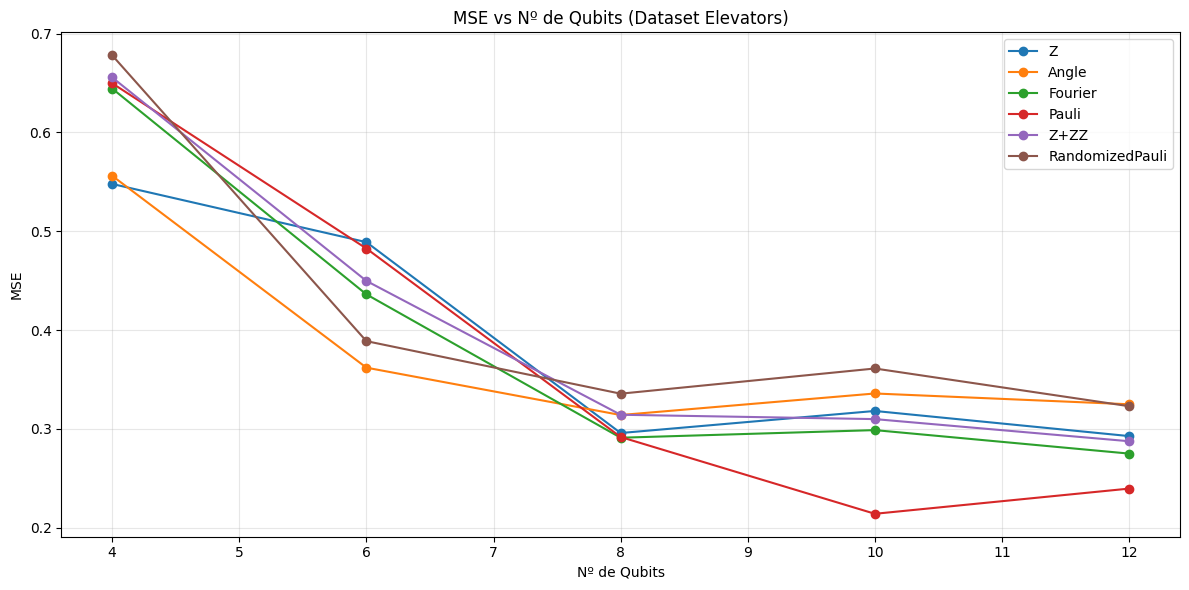

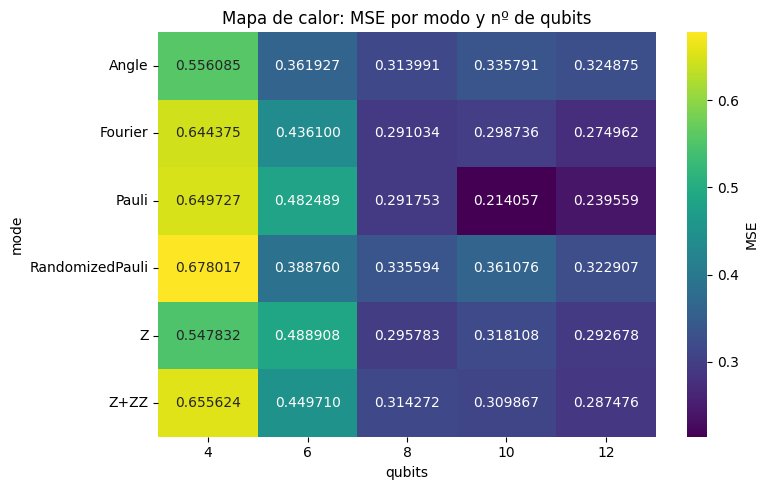

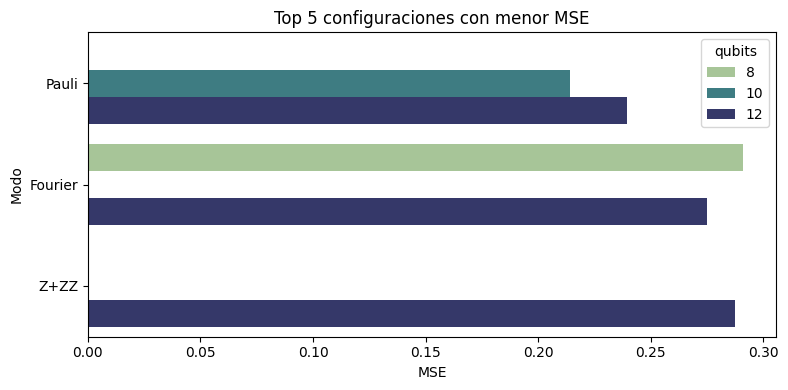

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pega aquí tu log completo (todo el texto desde === Optimizando ... hasta el final)
log_text = """
=== Optimizando Z con 4 qubits ===
[I 2025-11-10 12:44:42,626] Trial 0 finished with value: 0.7354682371815167 and parameters: {'C': 0.16548468800373964, 'epsilon': 0.06856913701845475, 'kernel': 'linear'}. Best is trial 0 with value: 0.7354682371815167.
[I 2025-11-10 12:44:43,824] Trial 1 finished with value: 0.547831847545888 and parameters: {'C': 0.5232734143285048, 'epsilon': 0.10951974501068966, 'kernel': 'poly'}. Best is trial 1 with value: 0.547831847545888.
[I 2025-11-10 12:44:44,727] Trial 2 finished with value: 0.7241713947333592 and parameters: {'C': 1.7242278166882448, 'epsilon': 0.1541677079686908, 'kernel': 'linear'}. Best is trial 1 with value: 0.547831847545888.
[I 2025-11-10 12:44:44,733] A new study created in memory with name: no-name-7da1eaca-ae85-44d5-8719-171bb341b8ce
→ Mejor trial: MSE=0.547832, kernel=poly, C=0.523, eps=0.110

=== Optimizando Z+ZZ con 4 qubits ===
[I 2025-11-10 12:44:56,864] Trial 0 finished with value: 0.6556238482241349 and parameters: {'C': 0.20996618319941654, 'epsilon': 0.026474166081100585, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6556238482241349.
[I 2025-11-10 12:45:08,485] Trial 1 finished with value: 0.7918012191243926 and parameters: {'C': 0.6860106588119397, 'epsilon': 0.1669800153979048, 'kernel': 'linear'}. Best is trial 0 with value: 0.6556238482241349.
[I 2025-11-10 12:45:12,939] Trial 2 finished with value: 0.7738033324176308 and parameters: {'C': 0.3493799381452744, 'epsilon': 0.21355415128393704, 'kernel': 'linear'}. Best is trial 0 with value: 0.6556238482241349.
[I 2025-11-10 12:45:12,941] A new study created in memory with name: no-name-d422b323-b6d0-482e-b53b-393fd26c393b
→ Mejor trial: MSE=0.655624, kernel=rbf, C=0.210, eps=0.026

=== Optimizando Pauli con 4 qubits ===
[I 2025-11-10 12:45:17,640] Trial 0 finished with value: 0.6658743729584115 and parameters: {'C': 0.1559481617713125, 'epsilon': 0.13385622887616538, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6658743729584115.
[I 2025-11-10 12:45:25,566] Trial 1 finished with value: 0.6497270345110548 and parameters: {'C': 0.2131731399148468, 'epsilon': 0.1825894996949071, 'kernel': 'rbf'}. Best is trial 1 with value: 0.6497270345110548.
[I 2025-11-10 12:45:30,428] Trial 2 finished with value: 0.6873095660573798 and parameters: {'C': 0.16304149275765395, 'epsilon': 0.29556821999281174, 'kernel': 'poly'}. Best is trial 1 with value: 0.6497270345110548.
[I 2025-11-10 12:45:30,431] A new study created in memory with name: no-name-e9e12f24-bace-46f5-9ce4-9f98763873db
→ Mejor trial: MSE=0.649727, kernel=rbf, C=0.213, eps=0.183

=== Optimizando Angle con 4 qubits ===
[I 2025-11-10 12:45:31,087] Trial 0 finished with value: 0.6983920109836699 and parameters: {'C': 0.20384558134460437, 'epsilon': 0.20392359689533515, 'kernel': 'linear'}. Best is trial 0 with value: 0.6983920109836699.
[I 2025-11-10 12:45:31,685] Trial 1 finished with value: 0.556085380137987 and parameters: {'C': 8.867856546155716, 'epsilon': 0.051134377822263447, 'kernel': 'poly'}. Best is trial 1 with value: 0.556085380137987.
[I 2025-11-10 12:45:32,164] Trial 2 finished with value: 0.7644624000803537 and parameters: {'C': 0.5424200279306275, 'epsilon': 0.08650321338456263, 'kernel': 'linear'}. Best is trial 1 with value: 0.556085380137987.
[I 2025-11-10 12:45:32,166] A new study created in memory with name: no-name-f3b864e5-7ad7-47f8-8973-d9eee438a144
→ Mejor trial: MSE=0.556085, kernel=poly, C=8.868, eps=0.051

=== Optimizando Fourier con 4 qubits ===
[I 2025-11-10 12:45:32,720] Trial 0 finished with value: 0.6443751348280753 and parameters: {'C': 0.1626059685839688, 'epsilon': 0.07178535740522073, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6443751348280753.
[I 2025-11-10 12:45:33,254] Trial 1 finished with value: 0.9333050874973412 and parameters: {'C': 0.1330919846632945, 'epsilon': 0.12896666175957913, 'kernel': 'poly'}. Best is trial 0 with value: 0.6443751348280753.
[I 2025-11-10 12:45:33,800] Trial 2 finished with value: 0.9345986940560822 and parameters: {'C': 0.2181811964100647, 'epsilon': 0.1653771857651518, 'kernel': 'poly'}. Best is trial 0 with value: 0.6443751348280753.
[I 2025-11-10 12:45:33,801] A new study created in memory with name: no-name-48663155-9dd8-43dd-bb11-7d4b3402eca6
→ Mejor trial: MSE=0.644375, kernel=rbf, C=0.163, eps=0.072

=== Optimizando RandomizedPauli con 4 qubits ===
[I 2025-11-10 12:45:34,592] Trial 0 finished with value: 0.7729855076286801 and parameters: {'C': 5.2258273343385975, 'epsilon': 0.2584927006648182, 'kernel': 'linear'}. Best is trial 0 with value: 0.7729855076286801.
[I 2025-11-10 12:45:35,356] Trial 1 finished with value: 0.7775367385958944 and parameters: {'C': 2.962757867910044, 'epsilon': 0.2386076944488573, 'kernel': 'linear'}. Best is trial 0 with value: 0.7729855076286801.
[I 2025-11-10 12:45:36,094] Trial 2 finished with value: 0.6780171930931911 and parameters: {'C': 0.2556262776040067, 'epsilon': 0.2020855818284575, 'kernel': 'poly'}. Best is trial 2 with value: 0.6780171930931911.
[I 2025-11-10 12:45:36,096] A new study created in memory with name: no-name-3f2a233a-3d5a-4064-8013-66896804a460
→ Mejor trial: MSE=0.678017, kernel=poly, C=0.256, eps=0.202

=== Optimizando Z con 6 qubits ===
[I 2025-11-10 12:45:36,767] Trial 0 finished with value: 0.6861645098179188 and parameters: {'C': 7.069117135790758, 'epsilon': 0.2797988971183092, 'kernel': 'linear'}. Best is trial 0 with value: 0.6861645098179188.
[I 2025-11-10 12:45:37,636] Trial 1 finished with value: 0.488907791933903 and parameters: {'C': 0.12619092937212573, 'epsilon': 0.2862324047796425, 'kernel': 'poly'}. Best is trial 1 with value: 0.488907791933903.
[I 2025-11-10 12:45:38,258] Trial 2 finished with value: 0.6860197861755084 and parameters: {'C': 0.40667026740255613, 'epsilon': 0.15763165071951402, 'kernel': 'linear'}. Best is trial 1 with value: 0.488907791933903.
[I 2025-11-10 12:45:38,259] A new study created in memory with name: no-name-dd8ae8d8-470b-445c-8db1-f6f72be2efc5
→ Mejor trial: MSE=0.488908, kernel=poly, C=0.126, eps=0.286

=== Optimizando Z+ZZ con 6 qubits ===
[I 2025-11-10 12:45:46,550] Trial 0 finished with value: 1.0763886452856437 and parameters: {'C': 2.050651712266501, 'epsilon': 0.2089742208002993, 'kernel': 'poly'}. Best is trial 0 with value: 1.0763886452856437.
[I 2025-11-10 12:45:54,251] Trial 1 finished with value: 0.578780414001242 and parameters: {'C': 0.17186641925648194, 'epsilon': 0.16210253925016896, 'kernel': 'rbf'}. Best is trial 1 with value: 0.578780414001242.
[I 2025-11-10 12:46:02,653] Trial 2 finished with value: 0.4497096310014664 and parameters: {'C': 0.7277127399179094, 'epsilon': 0.08439879943184042, 'kernel': 'rbf'}. Best is trial 2 with value: 0.4497096310014664.
[I 2025-11-10 12:46:02,656] A new study created in memory with name: no-name-a2c013c8-1f74-4be9-89ab-61f5a29cc0a3
→ Mejor trial: MSE=0.449710, kernel=rbf, C=0.728, eps=0.084

=== Optimizando Pauli con 6 qubits ===
[I 2025-11-10 12:46:09,250] Trial 0 finished with value: 0.4824891546739087 and parameters: {'C': 0.4328811980825456, 'epsilon': 0.16382728799119903, 'kernel': 'rbf'}. Best is trial 0 with value: 0.4824891546739087.
[I 2025-11-10 12:46:15,244] Trial 1 finished with value: 0.5492763889580928 and parameters: {'C': 0.33960542325069476, 'epsilon': 0.03901176944315579, 'kernel': 'poly'}. Best is trial 0 with value: 0.4824891546739087.
[I 2025-11-10 12:46:21,936] Trial 2 finished with value: 0.6190414159692871 and parameters: {'C': 0.11158316846586987, 'epsilon': 0.21558519155761713, 'kernel': 'poly'}. Best is trial 0 with value: 0.4824891546739087.
[I 2025-11-10 12:46:21,939] A new study created in memory with name: no-name-4ca9bf1b-b9f5-4cfd-bcb4-2c164e4cb931
→ Mejor trial: MSE=0.482489, kernel=rbf, C=0.433, eps=0.164

=== Optimizando Angle con 6 qubits ===
[I 2025-11-10 12:46:22,695] Trial 0 finished with value: 0.36192725645215373 and parameters: {'C': 9.814587986039733, 'epsilon': 0.09386536318230104, 'kernel': 'rbf'}. Best is trial 0 with value: 0.36192725645215373.
[I 2025-11-10 12:46:23,400] Trial 1 finished with value: 0.569047558186011 and parameters: {'C': 0.13092942476020414, 'epsilon': 0.04130377863278031, 'kernel': 'rbf'}. Best is trial 0 with value: 0.36192725645215373.
[I 2025-11-10 12:46:24,083] Trial 2 finished with value: 0.7107317381857725 and parameters: {'C': 0.21634623251597804, 'epsilon': 0.20681968005256013, 'kernel': 'linear'}. Best is trial 0 with value: 0.36192725645215373.
[I 2025-11-10 12:46:24,085] A new study created in memory with name: no-name-da432b88-55c6-4a0e-9d77-6895bed4a457
→ Mejor trial: MSE=0.361927, kernel=rbf, C=9.815, eps=0.094

=== Optimizando Fourier con 6 qubits ===
[I 2025-11-10 12:46:24,900] Trial 0 finished with value: 0.8761664135410059 and parameters: {'C': 0.11988347709377224, 'epsilon': 0.011293304311231843, 'kernel': 'poly'}. Best is trial 0 with value: 0.8761664135410059.
[I 2025-11-10 12:46:25,718] Trial 1 finished with value: 0.8800309097621697 and parameters: {'C': 0.1975433475956195, 'epsilon': 0.024127352788111737, 'kernel': 'poly'}. Best is trial 0 with value: 0.8761664135410059.
[I 2025-11-10 12:46:26,533] Trial 2 finished with value: 0.4360999235109061 and parameters: {'C': 0.7027079172535753, 'epsilon': 0.03464510190534694, 'kernel': 'rbf'}. Best is trial 2 with value: 0.4360999235109061.
[I 2025-11-10 12:46:26,535] A new study created in memory with name: no-name-b01d5e8d-bc71-4242-87df-7622c32a5d14
→ Mejor trial: MSE=0.436100, kernel=rbf, C=0.703, eps=0.035

=== Optimizando RandomizedPauli con 6 qubits ===
[I 2025-11-10 12:46:27,656] Trial 0 finished with value: 0.6369527190372983 and parameters: {'C': 4.138963117737848, 'epsilon': 0.06973769889050666, 'kernel': 'poly'}. Best is trial 0 with value: 0.6369527190372983.
[I 2025-11-10 12:46:28,760] Trial 1 finished with value: 0.5619324680925911 and parameters: {'C': 0.5519997453037662, 'epsilon': 0.01272160049102136, 'kernel': 'poly'}. Best is trial 1 with value: 0.5619324680925911.
[I 2025-11-10 12:46:29,874] Trial 2 finished with value: 0.38876031883674383 and parameters: {'C': 2.4618685513468126, 'epsilon': 0.11416392343172656, 'kernel': 'rbf'}. Best is trial 2 with value: 0.38876031883674383.
[I 2025-11-10 12:46:29,876] A new study created in memory with name: no-name-ef4cb917-eebb-4dd6-847b-7ee946dddc06
→ Mejor trial: MSE=0.388760, kernel=rbf, C=2.462, eps=0.114

=== Optimizando Z con 8 qubits ===
[I 2025-11-10 12:46:32,089] Trial 0 finished with value: 0.30192329760372616 and parameters: {'C': 4.4387299638191, 'epsilon': 0.15626721378117325, 'kernel': 'rbf'}. Best is trial 0 with value: 0.30192329760372616.
[I 2025-11-10 12:46:34,534] Trial 1 finished with value: 0.29578304707169434 and parameters: {'C': 1.5462217653796615, 'epsilon': 0.2490579450691921, 'kernel': 'poly'}. Best is trial 1 with value: 0.29578304707169434.
[I 2025-11-10 12:46:35,575] Trial 2 finished with value: 0.29700161899029154 and parameters: {'C': 0.3669296888184321, 'epsilon': 0.0973026799298916, 'kernel': 'linear'}. Best is trial 1 with value: 0.29578304707169434.
[I 2025-11-10 12:46:35,577] A new study created in memory with name: no-name-7c7bd95c-52e8-4f14-beef-cd9532febcce
→ Mejor trial: MSE=0.295783, kernel=poly, C=1.546, eps=0.249

=== Optimizando Z+ZZ con 8 qubits ===
[I 2025-11-10 12:46:49,039] Trial 0 finished with value: 0.3142717633841538 and parameters: {'C': 2.4010910196327737, 'epsilon': 0.16026770517745126, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3142717633841538.
[I 2025-11-10 12:47:02,155] Trial 1 finished with value: 0.6934077485191115 and parameters: {'C': 0.15291814199428388, 'epsilon': 0.24576664883617155, 'kernel': 'poly'}. Best is trial 0 with value: 0.3142717633841538.
[I 2025-11-10 12:47:15,310] Trial 2 finished with value: 0.32627123208128705 and parameters: {'C': 0.7251563501053787, 'epsilon': 0.2706955394049791, 'kernel': 'linear'}. Best is trial 0 with value: 0.3142717633841538.
[I 2025-11-10 12:47:15,312] A new study created in memory with name: no-name-06b34071-afd1-49e8-bd3d-5afe22ab0180
→ Mejor trial: MSE=0.314272, kernel=rbf, C=2.401, eps=0.160

=== Optimizando Pauli con 8 qubits ===
[I 2025-11-10 12:47:22,940] Trial 0 finished with value: 0.29948434668337875 and parameters: {'C': 2.0791092866621814, 'epsilon': 0.16488197264786444, 'kernel': 'rbf'}. Best is trial 0 with value: 0.29948434668337875.
[I 2025-11-10 12:47:31,392] Trial 1 finished with value: 0.2917530717587992 and parameters: {'C': 1.7463688152705896, 'epsilon': 0.21983361536706833, 'kernel': 'rbf'}. Best is trial 1 with value: 0.2917530717587992.
[I 2025-11-10 12:47:39,802] Trial 2 finished with value: 0.3900396908454602 and parameters: {'C': 0.10390814367683034, 'epsilon': 0.15985401443795214, 'kernel': 'poly'}. Best is trial 1 with value: 0.2917530717587992.
[I 2025-11-10 12:47:39,805] A new study created in memory with name: no-name-006ef8f4-63f6-4092-bc93-35652902ae6a
→ Mejor trial: MSE=0.291753, kernel=rbf, C=1.746, eps=0.220

=== Optimizando Angle con 8 qubits ===
[I 2025-11-10 12:47:40,831] Trial 0 finished with value: 0.4977198220273264 and parameters: {'C': 0.19156280591902475, 'epsilon': 0.0829560890598315, 'kernel': 'poly'}. Best is trial 0 with value: 0.4977198220273264.
[I 2025-11-10 12:47:41,862] Trial 1 finished with value: 0.313990633512802 and parameters: {'C': 0.12073918963130145, 'epsilon': 0.19767898112024943, 'kernel': 'linear'}. Best is trial 1 with value: 0.313990633512802.
[I 2025-11-10 12:47:42,894] Trial 2 finished with value: 0.4012521754419922 and parameters: {'C': 0.3710689899094507, 'epsilon': 0.22247715685923694, 'kernel': 'rbf'}. Best is trial 1 with value: 0.313990633512802.
[I 2025-11-10 12:47:42,896] A new study created in memory with name: no-name-eb683d76-2325-4c29-abcf-871e0b27e6b1
→ Mejor trial: MSE=0.313991, kernel=linear, C=0.121, eps=0.198

=== Optimizando Fourier con 8 qubits ===
[I 2025-11-10 12:47:44,090] Trial 0 finished with value: 0.3611177259227426 and parameters: {'C': 6.280543415116311, 'epsilon': 0.022851832952433024, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3611177259227426.
[I 2025-11-10 12:47:45,248] Trial 1 finished with value: 0.2910342129376133 and parameters: {'C': 2.6533441553860597, 'epsilon': 0.2257539771410401, 'kernel': 'linear'}. Best is trial 1 with value: 0.2910342129376133.
[I 2025-11-10 12:47:46,444] Trial 2 finished with value: 0.6518576270727516 and parameters: {'C': 0.9448299351032287, 'epsilon': 0.09427763300672272, 'kernel': 'poly'}. Best is trial 1 with value: 0.2910342129376133.
[I 2025-11-10 12:47:46,447] A new study created in memory with name: no-name-22307fd8-d0a6-4e63-be88-69c0c344670a
→ Mejor trial: MSE=0.291034, kernel=linear, C=2.653, eps=0.226

=== Optimizando RandomizedPauli con 8 qubits ===
[I 2025-11-10 12:47:48,023] Trial 0 finished with value: 0.33826685722092265 and parameters: {'C': 1.3028038714921, 'epsilon': 0.12113876390374244, 'kernel': 'rbf'}. Best is trial 0 with value: 0.33826685722092265.
[I 2025-11-10 12:47:50,722] Trial 1 finished with value: 0.3575334176183366 and parameters: {'C': 0.911761445592738, 'epsilon': 0.013510800142674978, 'kernel': 'linear'}. Best is trial 0 with value: 0.33826685722092265.
[I 2025-11-10 12:47:52,364] Trial 2 finished with value: 0.335593632120769 and parameters: {'C': 4.786065357482801, 'epsilon': 0.15537090881385088, 'kernel': 'rbf'}. Best is trial 2 with value: 0.335593632120769.
[I 2025-11-10 12:47:52,366] A new study created in memory with name: no-name-47990628-adcc-4c29-a470-d4eb2fc32d63
→ Mejor trial: MSE=0.335594, kernel=rbf, C=4.786, eps=0.155

=== Optimizando Z con 10 qubits ===
[I 2025-11-10 12:47:53,678] Trial 0 finished with value: 0.31810830232357756 and parameters: {'C': 8.497659066088435, 'epsilon': 0.044313894535235786, 'kernel': 'rbf'}. Best is trial 0 with value: 0.31810830232357756.
[I 2025-11-10 12:47:55,001] Trial 1 finished with value: 0.33417071937027093 and parameters: {'C': 2.7712412857757807, 'epsilon': 0.2684442251046416, 'kernel': 'poly'}. Best is trial 0 with value: 0.31810830232357756.
[I 2025-11-10 12:47:56,320] Trial 2 finished with value: 0.33582422740173334 and parameters: {'C': 3.1203103661867133, 'epsilon': 0.20210760539330808, 'kernel': 'poly'}. Best is trial 0 with value: 0.31810830232357756.
[I 2025-11-10 12:47:56,322] A new study created in memory with name: no-name-89894fbd-a9a6-44d1-bbb0-896a7d77c85d
→ Mejor trial: MSE=0.318108, kernel=rbf, C=8.498, eps=0.044

=== Optimizando Z+ZZ con 10 qubits ===
[I 2025-11-10 12:48:16,784] Trial 0 finished with value: 0.6826273159157122 and parameters: {'C': 0.1581376224814088, 'epsilon': 0.06621600290446383, 'kernel': 'poly'}. Best is trial 0 with value: 0.6826273159157122.
[I 2025-11-10 12:48:36,969] Trial 1 finished with value: 0.30986717908892203 and parameters: {'C': 3.8491777150691426, 'epsilon': 0.2365440758289892, 'kernel': 'rbf'}. Best is trial 1 with value: 0.30986717908892203.
[I 2025-11-10 12:48:57,947] Trial 2 finished with value: 0.31442366330425925 and parameters: {'C': 3.608854636867929, 'epsilon': 0.06121895601749907, 'kernel': 'linear'}. Best is trial 1 with value: 0.30986717908892203.
[I 2025-11-10 12:48:57,950] A new study created in memory with name: no-name-b9eb71fd-b9b7-44a7-88d0-76897bfdd6cf
→ Mejor trial: MSE=0.309867, kernel=rbf, C=3.849, eps=0.237

=== Optimizando Pauli con 10 qubits ===
[I 2025-11-10 12:49:08,679] Trial 0 finished with value: 0.2431877200394114 and parameters: {'C': 0.13376742018751808, 'epsilon': 0.016557874903244577, 'kernel': 'linear'}. Best is trial 0 with value: 0.2431877200394114.
[I 2025-11-10 12:49:19,207] Trial 1 finished with value: 0.21405731005026452 and parameters: {'C': 3.785880309911255, 'epsilon': 0.2144553225728682, 'kernel': 'linear'}. Best is trial 1 with value: 0.21405731005026452.
[I 2025-11-10 12:49:28,890] Trial 2 finished with value: 0.28929410776361975 and parameters: {'C': 5.36010083935537, 'epsilon': 0.02998492772305672, 'kernel': 'rbf'}. Best is trial 1 with value: 0.21405731005026452.
[I 2025-11-10 12:49:28,894] A new study created in memory with name: no-name-7689207e-a2ab-4b77-b7e8-7cbe24769bf8
→ Mejor trial: MSE=0.214057, kernel=linear, C=3.786, eps=0.214

=== Optimizando Angle con 10 qubits ===
[I 2025-11-10 12:49:30,890] Trial 0 finished with value: 0.33827200163663473 and parameters: {'C': 0.7336462217659158, 'epsilon': 0.23945092186426506, 'kernel': 'rbf'}. Best is trial 0 with value: 0.33827200163663473.
[I 2025-11-10 12:49:32,892] Trial 1 finished with value: 0.3357907424892268 and parameters: {'C': 0.4433154527767646, 'epsilon': 0.29768984949949245, 'kernel': 'linear'}. Best is trial 1 with value: 0.3357907424892268.
[I 2025-11-10 12:49:34,396] Trial 2 finished with value: 0.3436875989862217 and parameters: {'C': 0.8860719671999622, 'epsilon': 0.280366046472331, 'kernel': 'linear'}. Best is trial 1 with value: 0.3357907424892268.
[I 2025-11-10 12:49:34,397] A new study created in memory with name: no-name-b5b576fa-27f7-4382-8bdf-9db4332c2414
→ Mejor trial: MSE=0.335791, kernel=linear, C=0.443, eps=0.298

=== Optimizando Fourier con 10 qubits ===
[I 2025-11-10 12:49:36,074] Trial 0 finished with value: 0.3435439128053195 and parameters: {'C': 0.30577950458137065, 'epsilon': 0.18963654767284419, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3435439128053195.
[I 2025-11-10 12:49:37,763] Trial 1 finished with value: 0.6121077616617783 and parameters: {'C': 0.489594378301771, 'epsilon': 0.19538268147199836, 'kernel': 'poly'}. Best is trial 0 with value: 0.3435439128053195.
[I 2025-11-10 12:49:39,420] Trial 2 finished with value: 0.29873646593891146 and parameters: {'C': 0.5198367905611315, 'epsilon': 0.26475118726251745, 'kernel': 'rbf'}. Best is trial 2 with value: 0.29873646593891146.
[I 2025-11-10 12:49:39,422] A new study created in memory with name: no-name-74077107-b25f-43f6-ac5b-a0f7aa5ae1ce
→ Mejor trial: MSE=0.298736, kernel=rbf, C=0.520, eps=0.265

=== Optimizando RandomizedPauli con 10 qubits ===
[I 2025-11-10 12:49:41,899] Trial 0 finished with value: 0.36107631623369374 and parameters: {'C': 2.8315725959970397, 'epsilon': 0.25895286804165774, 'kernel': 'linear'}. Best is trial 0 with value: 0.36107631623369374.
[I 2025-11-10 12:49:45,233] Trial 1 finished with value: 0.3688814849100113 and parameters: {'C': 1.2948362884811537, 'epsilon': 0.03565661363906443, 'kernel': 'poly'}. Best is trial 0 with value: 0.36107631623369374.
[I 2025-11-10 12:49:47,561] Trial 2 finished with value: 0.5991442561555567 and parameters: {'C': 0.10584354442644675, 'epsilon': 0.01696502487669973, 'kernel': 'poly'}. Best is trial 0 with value: 0.36107631623369374.
[I 2025-11-10 12:49:47,564] A new study created in memory with name: no-name-a4312466-fb91-4e03-b97a-c5abb69afb3f
→ Mejor trial: MSE=0.361076, kernel=linear, C=2.832, eps=0.259

=== Optimizando Z con 12 qubits ===
[I 2025-11-10 12:49:50,002] Trial 0 finished with value: 0.302563384062404 and parameters: {'C': 8.788994728734796, 'epsilon': 0.141668285088134, 'kernel': 'rbf'}. Best is trial 0 with value: 0.302563384062404.
[I 2025-11-10 12:49:52,158] Trial 1 finished with value: 0.29267815368397837 and parameters: {'C': 0.4829287673314773, 'epsilon': 0.06833958943621855, 'kernel': 'rbf'}. Best is trial 1 with value: 0.29267815368397837.
[I 2025-11-10 12:49:54,322] Trial 2 finished with value: 0.33854780838088444 and parameters: {'C': 1.9390798842252588, 'epsilon': 0.11177697073924231, 'kernel': 'poly'}. Best is trial 1 with value: 0.29267815368397837.
[I 2025-11-10 12:49:54,323] A new study created in memory with name: no-name-a1520ef4-30ab-447c-9d99-00159babba17
→ Mejor trial: MSE=0.292678, kernel=rbf, C=0.483, eps=0.068

=== Optimizando Z+ZZ con 12 qubits ===
[I 2025-11-10 12:50:27,105] Trial 0 finished with value: 0.287475974667468 and parameters: {'C': 0.7574780724295512, 'epsilon': 0.17880819649546986, 'kernel': 'rbf'}. Best is trial 0 with value: 0.287475974667468.
[I 2025-11-10 12:50:59,331] Trial 1 finished with value: 0.5603462137954882 and parameters: {'C': 1.3329466103283512, 'epsilon': 0.13942602467980347, 'kernel': 'poly'}. Best is trial 0 with value: 0.287475974667468.
[I 2025-11-10 12:51:31,892] Trial 2 finished with value: 0.4895763196769694 and parameters: {'C': 0.11839975003495708, 'epsilon': 0.037856969386808825, 'kernel': 'rbf'}. Best is trial 0 with value: 0.287475974667468.
[I 2025-11-10 12:51:31,894] A new study created in memory with name: no-name-7ccf7aa6-374d-46a2-b69f-6a9132bb7c7b
→ Mejor trial: MSE=0.287476, kernel=rbf, C=0.757, eps=0.179

=== Optimizando Pauli con 12 qubits ===
[I 2025-11-10 12:51:45,868] Trial 0 finished with value: 0.40747177721127525 and parameters: {'C': 5.330189937644226, 'epsilon': 0.19573097797251993, 'kernel': 'poly'}. Best is trial 0 with value: 0.40747177721127525.
[I 2025-11-10 12:51:59,907] Trial 1 finished with value: 0.5158578144483074 and parameters: {'C': 9.818009154856604, 'epsilon': 0.07803255004594799, 'kernel': 'poly'}. Best is trial 0 with value: 0.40747177721127525.
[I 2025-11-10 12:52:13,988] Trial 2 finished with value: 0.23955897031975296 and parameters: {'C': 0.43175760955766906, 'epsilon': 0.09181592426612918, 'kernel': 'linear'}. Best is trial 2 with value: 0.23955897031975296.
[I 2025-11-10 12:52:13,991] A new study created in memory with name: no-name-23fb1553-c796-4b1d-828a-5f8c7a295f88
→ Mejor trial: MSE=0.239559, kernel=linear, C=0.432, eps=0.092

=== Optimizando Angle con 12 qubits ===
[I 2025-11-10 12:52:17,481] Trial 0 finished with value: 0.3248745313256475 and parameters: {'C': 0.6412841614367399, 'epsilon': 0.27787898987253107, 'kernel': 'linear'}. Best is trial 0 with value: 0.3248745313256475.
[I 2025-11-10 12:52:19,926] Trial 1 finished with value: 0.36426121439916875 and parameters: {'C': 0.6126174149994708, 'epsilon': 0.2219937325306651, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3248745313256475.
[I 2025-11-10 12:52:22,355] Trial 2 finished with value: 0.3543544360696661 and parameters: {'C': 0.7000357861748376, 'epsilon': 0.23474667202712884, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3248745313256475.
[I 2025-11-10 12:52:22,357] A new study created in memory with name: no-name-51fd76ed-ec50-4dfa-aa6e-5e5a18618e15
→ Mejor trial: MSE=0.324875, kernel=linear, C=0.641, eps=0.278

=== Optimizando Fourier con 12 qubits ===
[I 2025-11-10 12:52:25,125] Trial 0 finished with value: 0.5697263038667494 and parameters: {'C': 3.274523583268959, 'epsilon': 0.265427399536939, 'kernel': 'poly'}. Best is trial 0 with value: 0.5697263038667494.
[I 2025-11-10 12:52:28,577] Trial 1 finished with value: 0.27496242282397776 and parameters: {'C': 2.1029918176111964, 'epsilon': 0.21489105383219548, 'kernel': 'rbf'}. Best is trial 1 with value: 0.27496242282397776.
[I 2025-11-10 12:52:31,743] Trial 2 finished with value: 0.2794844963822093 and parameters: {'C': 1.2357108834903994, 'epsilon': 0.2980793118139487, 'kernel': 'rbf'}. Best is trial 1 with value: 0.27496242282397776.
[I 2025-11-10 12:52:31,745] A new study created in memory with name: no-name-edecd504-d417-4fdd-99ba-13d3d965e1f0
→ Mejor trial: MSE=0.274962, kernel=rbf, C=2.103, eps=0.215

=== Optimizando RandomizedPauli con 12 qubits ===
[I 2025-11-10 12:52:35,402] Trial 0 finished with value: 0.3338785873878191 and parameters: {'C': 5.953043259771173, 'epsilon': 0.12368086700555121, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3338785873878191.
[I 2025-11-10 12:52:39,184] Trial 1 finished with value: 0.3494405125402644 and parameters: {'C': 3.747014826237409, 'epsilon': 0.20566820195375332, 'kernel': 'linear'}. Best is trial 0 with value: 0.3338785873878191.
[I 2025-11-10 12:52:43,826] Trial 2 finished with value: 0.3229067487500489 and parameters: {'C': 0.3743041784170679, 'epsilon': 0.06602205817748448, 'kernel': 'linear'}. Best is trial 2 with value: 0.3229067487500489.
→ Mejor trial: MSE=0.322907, kernel=linear, C=0.374, eps=0.066
"""

# Extraer secciones
blocks = re.split(r"=== Optimizando ", log_text)
data = []

for b in blocks[1:]:
    try:
        # Extraer modo y qubits
        header = b.split(" ===")[0]
        mode, q = re.match(r"(.+?) con (\d+) qubits", header).groups()
        q = int(q)

        # Extraer mejor trial
        best = re.search(r"MSE=([\d\.eE\-]+), kernel=([a-z]+), C=([\d\.]+), eps=([\d\.]+)", b)
        if best:
            mse, kernel, C, eps = best.groups()
            data.append({
                "mode": mode.strip(),
                "qubits": q,
                "MSE": float(mse),
                "kernel": kernel,
                "C": float(C),
                "epsilon": float(eps)
            })
    except Exception as e:
        print("Error parsing block:", e)

# Crear DataFrame ordenado
df = pd.DataFrame(data)
df.sort_values(["qubits","MSE"], inplace=True)
df.reset_index(drop=True, inplace=True)

print("✅ Resultados extraídos:")
print(df.to_string(index=False))

# Graficar MSE vs qubits
plt.figure(figsize=(12,6))
for m in df["mode"].unique():
    sub = df[df["mode"]==m].sort_values("qubits")
    plt.plot(sub["qubits"], sub["MSE"], marker='o', label=m)
plt.title("MSE vs Nº de Qubits (Dataset Elevators)")
plt.xlabel("Nº de Qubits")
plt.ylabel("MSE")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap modo vs qubits
plt.figure(figsize=(8,5))
pivot = df.pivot(index="mode", columns="qubits", values="MSE")
sns.heatmap(pivot, annot=True, fmt=".6f", cmap="viridis", cbar_kws={"label":"MSE"})
plt.title("Mapa de calor: MSE por modo y nº de qubits")
plt.tight_layout()
plt.show()

#  Top 5 mejores resultados
top5 = df.nsmallest(5, "MSE")
plt.figure(figsize=(8,4))
sns.barplot(x="MSE", y="mode", hue="qubits", data=top5, palette="crest")
plt.title("Top 5 configuraciones con menor MSE")
plt.xlabel("MSE")
plt.ylabel("Modo")
plt.tight_layout()
plt.show()
